In [47]:
# Imports
from aiutils import CamouflagedAnimalsModel
from dataset import CamouflagedAnimalsDataset, colorMaskToOneHot

import lightning as L
from lightning.pytorch.callbacks import ModelSummary
import torch as T
from torchvision.transforms import v2 as TV
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import numpy as np

## Utility functions

In [48]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Dataset augmentation & normalization

torch.Size([3, 512, 512])


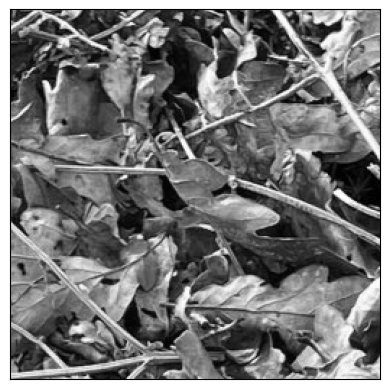

In [49]:
NoopTransform = TV.RandomHorizontalFlip(p=0.0)

# common transformations - applied to both the input & mask images
common_data_augment = TV.RandomChoice(
    [
        TV.RandomHorizontalFlip(p=1.0),
        TV.RandomRotation((-15, +15)),
        TV.RandomCrop(size=(256, 256), padding_mode="constant", pad_if_needed=True),
        NoopTransform
    ]
)
common_normalize = [
    TV.Resize((512, 512), interpolation=TV.InterpolationMode.NEAREST),
    TV.ToDtype(T.float, scale=True),
]
common_transform = TV.Compose([common_data_augment] + common_normalize)

# image transformations - applied only to the input images
# use IMAGENET transformations for input
image_transform = TV.RandomChoice(
    [
        TV.Grayscale(num_output_channels=3),
        TV.ColorJitter(brightness=0.5, hue=0.3),
        TV.GaussianBlur(kernel_size=(5, 9)),
        TV.RandomPosterize(p=1, bits=3),
        TV.RandomEqualize(p=1),
        TV.RandomSolarize(threshold=0.8, p=1),
        NoopTransform
    ]
)

# mask transformations - applied only to the mask images
# convert mask from RGB to one-hot mask with 4 channels
mask_transform = TV.Compose([colorMaskToOneHot])

dataset = CamouflagedAnimalsDataset(
    images_path="../images",
    masks_path="../masks",
    common_transform=common_transform,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

print(dataset[0][0].size())
show(dataset[0][0])

In [50]:
# enable TPU
T.set_float32_matmul_precision("medium")

# configure checkpoint
checkpoint_path: str | None = None
checkpoint_path = "C:/dev/biai/src/lightning_logs/version_12/checkpoints/epoch=11-step=588.ckpt"

if checkpoint_path is None:
    model_lightning = CamouflagedAnimalsModel()
else:
    model_lightning = CamouflagedAnimalsModel.load_from_checkpoint(checkpoint_path)

In [51]:
seed = T.Generator().manual_seed(42)
train_set, valid_set = T.utils.data.random_split(dataset, [0.9, 0.1], generator=seed)

train_loader = T.utils.data.DataLoader(
    train_set,
    batch_size=5,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
)
valid_loader = T.utils.data.DataLoader(
    valid_set,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
)

In [52]:
trainer = L.Trainer(
    limit_train_batches=250,
    accelerator="auto",
    devices="auto",
    strategy="auto",
    max_epochs=9999,
    callbacks=ModelSummary(max_depth=2),
    log_every_n_steps=5,
    # fast_dev_run=True
)
trainer.fit(
    model=model_lightning,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\dev\biai\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined